In [1]:
%matplotlib inline
from fastai.basics import *

## MNIST SGD

Get the 'pickled' MNIST dataset from http://deeplearning.net/data/mnist/mnist.pkl.gz. We're going to treat it as a standard flat dataset with fully connected layers, rather than using a CNN.

In [2]:
Config.DEFAULT_CONFIG_PATH = 'd:/fastaiconfig.yml'
path = Config().data_path()/'mnist'

In [3]:
path.ls()

[WindowsPath('d:/.fastai/data/mnist/mnist.pkl.gz')]

In [4]:
with gzip.open(path/'mnist.pkl.gz', 'rb') as f:
    ((x_train, y_train), (x_valid, y_valid), _) = pickle.load(f, encoding='latin-1')
x_train

array([[0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.],
       [0., 0., 0., 0., ..., 0., 0., 0., 0.]], dtype=float32)

(50000, 784)

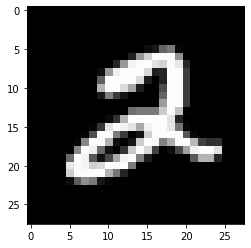

In [5]:
plt.imshow(x_train[5].reshape((28,28)), cmap="gray")
x_train.shape

In [6]:
x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
n,c = x_train.shape
x_train.shape, y_train.min(), y_train.max()

(torch.Size([50000, 784]), tensor(0), tensor(9))

In lesson2-sgd we did these things ourselves:

```python
x = torch.ones(n,2) 
def mse(y_hat, y): return ((y_hat-y)**2).mean()
y_hat = x@a
```

Now instead we'll use PyTorch's functions to do it for us, and also to handle mini-batches (which we didn't do last time, since our dataset was so small).

In [7]:
bs=256
train_ds = TensorDataset(x_train, y_train)
valid_ds = TensorDataset(x_valid, y_valid)
data = DataBunch.create(train_ds, valid_ds, bs=bs)
data.__dict__ #check attributes of class
#a = list(data.train_dl)
#len(a)

{'dl_tfms': [],
 'device': device(type='cuda'),
 'train_dl': DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x000002255A7C4208>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x00000225512CED08>),
 'valid_dl': DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x000002255A7C4048>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x00000225512CED08>),
 'fix_dl': DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x000002255A7C4DD8>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x00000225512CED08>),
 'test_dl': None,
 'single_dl': DeviceDataLoader(dl=<torch.utils.data.dataloader.DataLoader object at 0x000002255A7C46D8>, device=device(type='cuda'), tfms=[], collate_fn=<function data_collate at 0x00000225512CED08>),
 'path': WindowsPath('.')}

In [8]:
x,y = next(iter(data.train_dl))  #train_dl is training dataloader
x.shape,y.shape, x,y

(torch.Size([256, 784]),
 torch.Size([256]),
 tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]], device='cuda:0'),
 tensor([1, 6, 8, 6, 2, 9, 1, 5, 9, 9, 5, 4, 5, 3, 2, 7, 3, 1, 8, 3, 8, 0, 2, 7,
         3, 0, 9, 3, 9, 4, 5, 3, 9, 3, 0, 9, 9, 5, 5, 8, 3, 7, 1, 9, 5, 2, 5, 3,
         3, 3, 0, 9, 6, 8, 9, 1, 0, 3, 6, 7, 3, 4, 8, 3, 0, 4, 1, 4, 4, 7, 2, 0,
         1, 5, 3, 9, 8, 8, 1, 3, 4, 8, 1, 7, 7, 4, 9, 9, 6, 4, 7, 2, 8, 9, 7, 0,
         3, 4, 5, 2, 6, 4, 2, 0, 2, 4, 0, 8, 1, 0, 9, 8, 9, 9, 9, 9, 7, 3, 5, 2,
         6, 0, 4, 1, 2, 3, 2, 9, 3, 2, 4, 8, 0, 0, 3, 6, 7, 1, 5, 4, 2, 5, 7, 0,
         4, 5, 0, 9, 1, 9, 3, 6, 6, 2, 5, 9, 6, 9, 1, 4, 0, 5, 1, 9, 5, 0, 5, 5,
         2, 2, 7, 8, 3, 2, 6, 6, 3, 0, 1, 1, 5, 5, 5, 1, 6, 1, 6, 9, 8, 7, 1, 3,
         2, 5, 1, 9, 7, 9, 3

In [9]:
class Mnist_Logistic(nn.Module):
    def __init__(self):
        super().__init__() #this is to make sure this sub-class will excute the __init__ in upper class(nn.Module class)
        self.lin = nn.Linear(784, 10, bias=True) #nn.Linear will help create the bias column for us

    def forward(self, xb): return self.lin(xb)

In [10]:
model = Mnist_Logistic().cuda() #.cuda() puts the data batch on GPU

In [11]:
model

Mnist_Logistic(
  (lin): Linear(in_features=784, out_features=10, bias=True)
)

In [12]:
model.lin

Linear(in_features=784, out_features=10, bias=True)

In [13]:
model(x).shape

torch.Size([256, 10])

In [14]:
model.__dict__

{'_backend': <torch.nn.backends.thnn.THNNFunctionBackend at 0x2255071d198>,
 '_parameters': OrderedDict(),
 '_buffers': OrderedDict(),
 '_backward_hooks': OrderedDict(),
 '_forward_hooks': OrderedDict(),
 '_forward_pre_hooks': OrderedDict(),
 '_state_dict_hooks': OrderedDict(),
 '_load_state_dict_pre_hooks': OrderedDict(),
 '_modules': OrderedDict([('lin',
               Linear(in_features=784, out_features=10, bias=True))]),
 'training': True}

In [15]:
[p.shape for p in model.parameters()]


[torch.Size([10, 784]), torch.Size([10])]

In [16]:
lr=2e-2

In [17]:
loss_func = nn.CrossEntropyLoss() 
#this function has already got softmax function to make sure sume of activation values is 1, unlike that in pytorch

In [18]:
def update(x,y,lr):
    wd = 1e-5
    y_hat = model(x)
    # weight decay
    w2 = 0.
    for p in model.parameters(): w2 += (p**2).sum()
    # add to regular loss
    loss = loss_func(y_hat, y) + w2*wd
    loss.backward()
    with torch.no_grad():
        for p in model.parameters():
            p.sub_(lr * p.grad)
            p.grad.zero_()
    return loss.item()

In [19]:
losses = [update(x,y,lr) for x,y in data.train_dl]

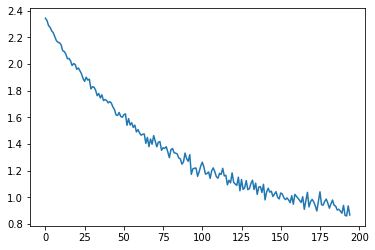

In [20]:
plt.plot(losses);

In [21]:
class Mnist_NN(nn.Module):
    def __init__(self):
        super().__init__()
        self.lin1 = nn.Linear(784, 50, bias=True)
        self.lin2 = nn.Linear(50, 10, bias=True)

    def forward(self, xb):
        x = self.lin1(xb)
        x = F.relu(x)
        return self.lin2(x)

In [22]:
model = Mnist_NN().cuda()

In [23]:
losses = [update(x,y,lr) for x,y in data.train_dl]

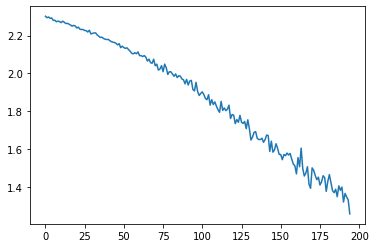

In [24]:
plt.plot(losses);

In [25]:
model = Mnist_NN().cuda()

In [36]:
def update(x,y,lr):
    opt = optim.Adam(model.parameters(), lr, weight_decay = 1e-3) # or optim.SGD
    y_hat = model(x)
    loss = loss_func(y_hat, y)
    loss.backward()
    opt.step()
    opt.zero_grad()
    return loss.item()

In [37]:
losses = [update(x,y,1e-3) for x,y in data.train_dl]

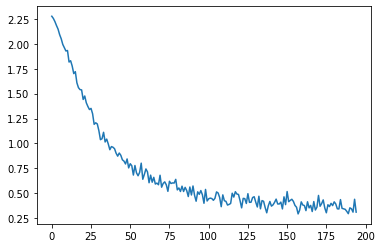

In [38]:
plt.plot(losses);

In [39]:
learn = Learner(data, Mnist_NN(), loss_func=loss_func, metrics=accuracy)

In [30]:
# %debug

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


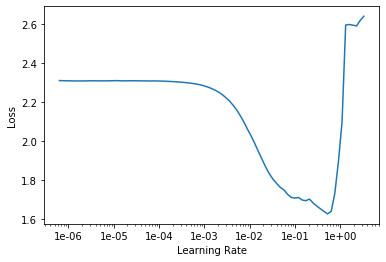

In [40]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(1, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.270908,0.197563,0.944100,00:09


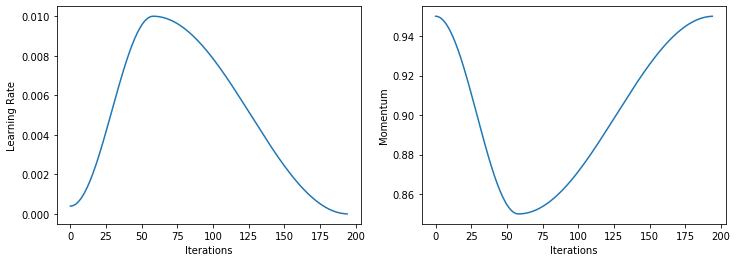

In [33]:
learn.recorder.plot_lr(show_moms=True)

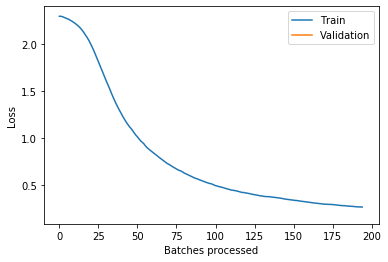

In [34]:
learn.recorder.plot_losses()

## fin